In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import mplhep as hep
import numpy as np
import torch_geometric.transforms as T
import GraphNN as G

from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc
from tqdm.notebook import tqdm

/lhome/ific/f/fkellere/miniconda/envs/IC-3.8-2022-04-13/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [ ]:
#file = "out_job_20250312_150538/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #Best performance new MC RadiusGraph no transform
#file = "out_job_20250407_152716/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC KNN 8 neighbors
#file = "out_job_20250328_170857/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC RadiusGraph with transform
#file = "out_job_20250407_175322/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #New MC Fully Connected
#file = "/lhome/ific/j/jrenner/gnn/out_job_20250402_182028/Loss_LargeNEWMC_LMDB.h5"
#file = "out_job_20250328_112257/Loss_RecoBig_all_10mm_R2.h5" #old MC with transform
#file = "out_job_20250408_150837/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 6 neighbors
#file = "out_job_20250411_110106/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 20 neighbors
#file = "out_job_20250414_120047/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 10 neighbors
#file = "out_job_20250416_122426/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 15 neighbors
#file = "out_job_20250414_142609/Loss_RecoNew_all_10mm_R2.h5" #KNN 10 neighbors VoxOpt (very bad!)
#file = "out_job_20250414_172230/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors node deletion pre-transform
#file = "out_job_20250422_124444/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 8 neighbors node deletion transform at the end
#file = "out_job_20250429_100740/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #KNN 10 neighbors node deletion at the beginning
#file = "out_job_20250502_121635/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors node deletion at the end
#file = "out_job_20250513_160535/Loss_RecoNew_all_10mm_KNN6_hitsopt.h5"
#file = "out_job_20250513_160232/Loss_RecoNew_all_10mm_KNN_hitsopt.h5"
#file = "out_job_20250513_161146/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5"
#file = "out_job_20250514_122809/Loss_RecoNew_all_10mm_FC_hitsopt.h5"
#file = "out_job_20250528_160734/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5" #KNN 20 neighbors node deletion at the end
#file = "out_job_20250619_084047/Loss_RecoNew_all_10mm_R2_hitsopt.h5" #R2 neighbors 400 epochs
#file = "out_job_20250619_085714/Loss_RecoNew_all_10mm_KNN6_hitsopt.h5" #KNN 6 neighbors 400 epochs
#file = "out_job_20250619_085805/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors 400 epochs
#file = "out_job_20250619_091550/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5" #KNN 20 neighbors 400 epochs
#file = "out_job_20250620_093500/Loss_RecoNew_all_10mm_KNN_hitsopt.h5" #KNN 10 neighbors 1000 epochs
#file = "out_job_20250620_092734/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5" #KNN 20 neighbors 1000 epochs
#file = "out_job_20250623_144936/Loss_RecoNew_all_10mm_FC_hitsopt.h5" #Fully Connected 400 epochs
#file = "out_job_20250708_174342/Loss_RecoNew_all_10mm_KNN30_hitsopt.h5" #KNN 30 neighbors 400 epochs
#file = "out_job_20250710_100656/Loss_RecoNew_all_10mm_FC_hitsopt.h5" #Fully Connected 5 attention heads
#file = "out_job_20250710_102816/Scores_Training.h5" #Fully Connected 6 attention heads
#file = "out_job_BIGDATASETKNN30R175/Scores_Training.h5" #KNN 30 neighbors radius 175
#file = "out_job_BIGDATASETKNN30R175/Scores_SmallDS.h5" #KNN 30 neighbors radius 175 trained on big dataset applied to small dataset
#file = "out_job_BIGDATASETKNN30R180/Scores_Training.h5" #KNN 30 neighbors radius 180
#file = "out_job_BIGDATASETKNN30R175STRICTVOXELS/Loss_BIGKNN30STRICT.h5"
#file = "out_job_20250708_174342/Scores_BIG180.h5" #KNN 30 neighbors 400 epochs trained on small dataset applied to big dataset 180 mm fiducial cut
#file = "out_job_20250708_174342/Scores_BIG175.h5" #KNN 30 neighbors 400 epochs trained on small dataset applied to big dataset 175 mm fiducial cut
#file = "out_job_StrictVoxTest/Loss_BIGsample_KNN30_r175_strictvox.h5" #strict voxelization - high performance - 280k dataset
#file = "out_job_20251008_163108/Loss_TestBIG175KNN30.h5" #variable voxels - 6 high performance (!) - 280k dataset
#file = "out_job_20251016_121241/Loss_TestBIG175KNN30.h5" #750k ordered variable voxel dataset - high performance
#file = "out_job_20251017_001725/Loss_BIGsample_KNN30_r175_strictvox.h5" #750k ordered strict voxel dataset - high performance
#file = "out_job_20251017_105057/Loss_BIGsample_KNN30_r175_strictvox.h5" #750k unordered strict voxel dataset - high performance
#file = "out_job_20250923_121517/Loss_TestBIG175KNN30.h5" #750k unordered variable voxel dataset - low performance
#file = "out_job_20251107_173434/Loss_TestBIG175KNN30.h5" #750k variable voxels KNN30 - high performance
#file = "out_job_20251107_153615/Loss_TestBIG175KNN40.h5" #750k variable voxels KNN40
#file = "out_job_20251113_130042/Loss_TestBIG175R3strict.h5" #750k strict voxels R3
#file = "out_job_20251113_130119/Loss_TestBIG175R3.h5" #750k variable voxels R3
#file = "out_job_20251118_153259/Loss_TestBIG175R3.h5" #750k variable voxels R3 higher dropout
#file = "out_job_20251118_153338/Loss_TestBIG175R3.h5" #750k variable voxels R3 higher dropout
#file = "out_job_20251118_153500/Loss_TestBIG175R3.h5" #750k variable voxels R3 higher dropout
#file = "out_job_20251118_153522/Loss_TestBIG175R3.h5" #750k variable voxels R3 higher dropout
#file = "out_job_20251118_153645/Loss_TestBIG175R3.h5" #750k variable voxels R3 higher dropout
#file = "out_job_BIGDATASETR3/Loss_BIGR3.h5" #5M R3 dataset variable voxels
#file = "out_job_BIGDATASETR3STRICT/Loss_BIGR3STRICT.h5" #5M R3 dataset strict voxels
#file = "out_job_20251202_093447/Loss_RandomSample5Mminus750k.h5" #variable voxels random sample
#file = "out_job_20260109_133839/Loss_RandomSampleFrom5M.h5" #strict voxels random sample
#file = "out_job_20251210_184956/Loss_TestBIG175R3.h5" #AdamW test
#file = "out_job_20251218_135124/Loss_RandomSampleFrom5M.h5" #1M random sample
#file = "out_job_20260108_170340/Loss_RandomSampleFrom5M.h5"
#file = "out_job_20260114_152407/Loss_RandomSampleFrom5M.h5" #GCNConv test
#file = "out_job_20260114_152431/Loss_RandomSampleFrom5M.h5" #GraphConv test
#file = "out_job_20260114_160115/Loss_RandomSampleFrom5M.h5" #GATConv test
#file = "out_job_20260119_165234/Loss_RandomSampleFrom5M.h5" #GATv2Conv test
#file = "out_job_20260114_164621/Loss_RandomSampleFrom5M.h5" #TransformerConv R1 test
#file = "out_job_20260115_102943/Loss_RandomSampleFrom5M.h5" #TransformerConv R2 test
#file = "out_job_20260120_100906/Loss_RandomSampleFrom5M.h5" #TransformerConv R3 test 
#file = "out_job_20260119_165330/Loss_RandomSampleFrom5M.h5" #TransformerConv R4 test
#file = "out_job_20260127_111443/Loss_RandomSampleFrom5M.h5" #TransformerConv R1 with 128 hidden dims test
file = "out_job_20260127_113306/Loss_RandomSampleFrom5M.h5" #TransformerConv R1 with 6 conv layers test
#file = "out_job_20260127_111443/Loss_RandomSampleFrom5M.h5" #Scores for TransformerConv R1 with 128 hidden dims test
# Load the data
y_test  = pd.read_hdf(file,'y_test')
y_pred  = pd.read_hdf(file,'y_predict_test')
Ltrain  = pd.read_hdf(file,'loss_train')
Lvalid  = pd.read_hdf(file,'loss_valid')
y_train = pd.read_hdf(file,'y_train')
y_pred_train = pd.read_hdf(file,'y_predict_train')
y_valid = pd.read_hdf(file,'y_valid')
y_pred_valid = pd.read_hdf(file,'y_predict_valid')

#y_pred = np.exp(y_pred)/(1+np.exp(y_pred))
#print('Number of events in dataset: ',len(pd.read_hdf(file,'y_predict_train'))+len(pd.read_hdf(file,'y_predict_valid'))+len(pd.read_hdf(file,'y_predict_test')))

In [16]:
len(y_train), len(y_valid), len(y_test)

(525000, 112500, 112500)

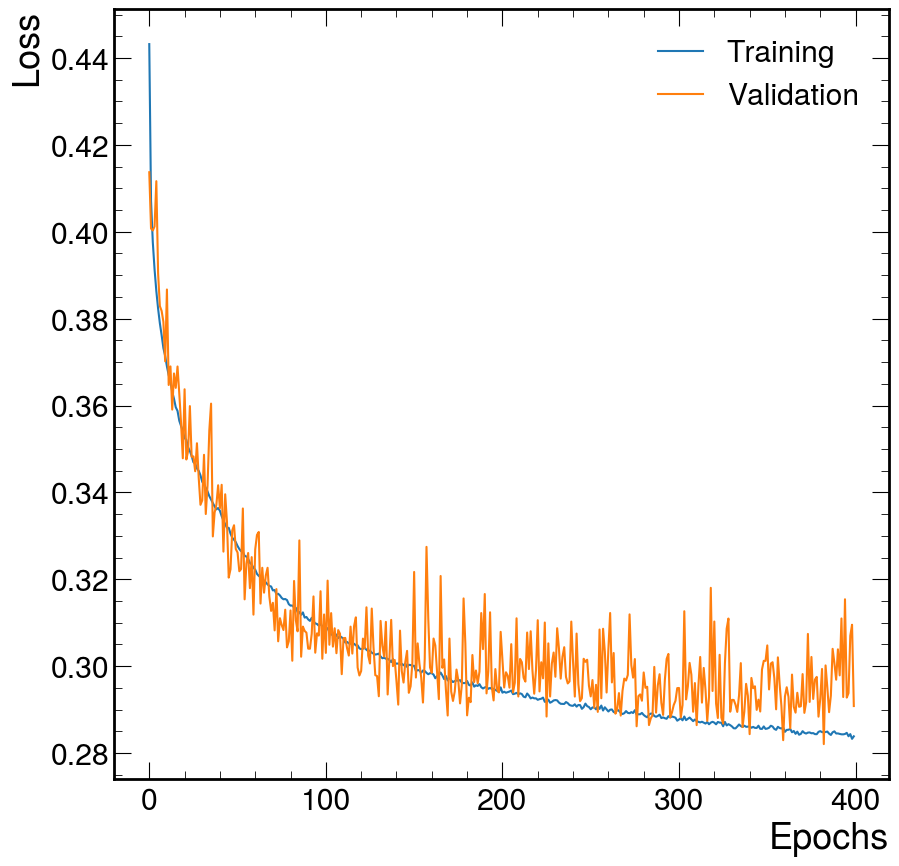

In [17]:
import re
loss_train = []
loss_valid = []

plt.style.use(hep.style.ROOT)
plt.plot(Ltrain,label='Training')
plt.plot(Lvalid,label='Validation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
#plt.ylim([0.3,0.62])
#plt.xlim([0,200])
plt.legend()

In [18]:
min(Lvalid['Validation Loss']), np.argmin(Lvalid['Validation Loss']), Ltrain['Train Loss'][np.argmin(Lvalid['Validation Loss'])]

(0.2820622900350441, 382, 0.2848035967120967)

In [19]:
plt.style.use(hep.style.ROOT)
# create ROC curves
try:
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_pred_train)
    fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, y_pred_valid)
    y_test = y_test.to_numpy()
    y_pred = y_pred.to_numpy()
    y_train = y_train.to_numpy()
    y_pred_train = y_pred_train.to_numpy()
    y_valid = y_valid.to_numpy()
    y_pred_valid = y_pred_valid.to_numpy()
except:
    y_test = np.array(y_test).flatten()
    y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
    y_train = np.array(y_train).flatten()
    y_pred_train = np.array(y_pred_train['Predicted Probability Class 1']).flatten()
    y_valid = np.array(y_valid).flatten()
    y_pred_valid = np.array(y_pred_valid['Predicted Probability Class 1']).flatten()
    fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    fpr_train, tpr_train, threshold_train = roc_curve(y_train, y_pred_train)
    fpr_valid, tpr_valid, threshold_valid = roc_curve(y_valid, y_pred_valid)

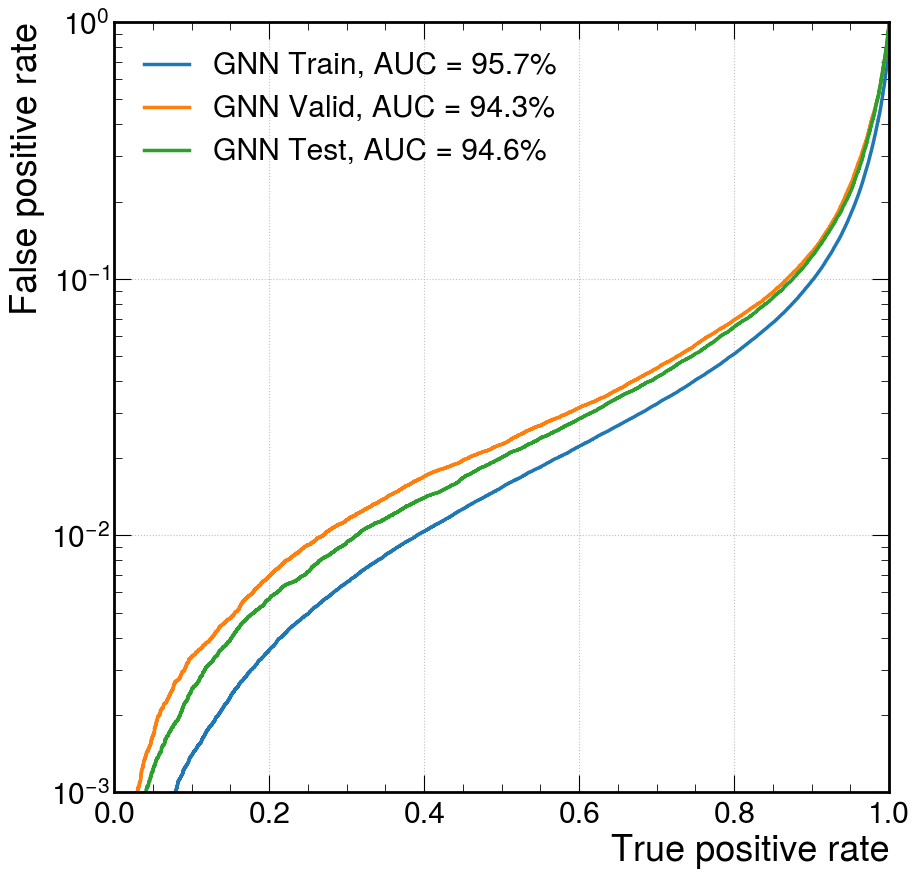

In [20]:

# plot ROC curves
plt.figure()
plt.plot(tpr_train, fpr_train, lw=2.5, label="GNN Train, AUC = {:.1f}%".format(auc(fpr_train,tpr_train)*100))
plt.plot(tpr_valid, fpr_valid, lw=2.5, label="GNN Valid, AUC = {:.1f}%".format(auc(fpr_valid,tpr_valid)*100))
plt.plot(tpr_gnn, fpr_gnn, lw=2.5, label="GNN Test, AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100))
plt.xlabel(r'True positive rate')
plt.ylabel(r'False positive rate')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

  0%|          | 0/112500 [00:00<?, ?it/s]

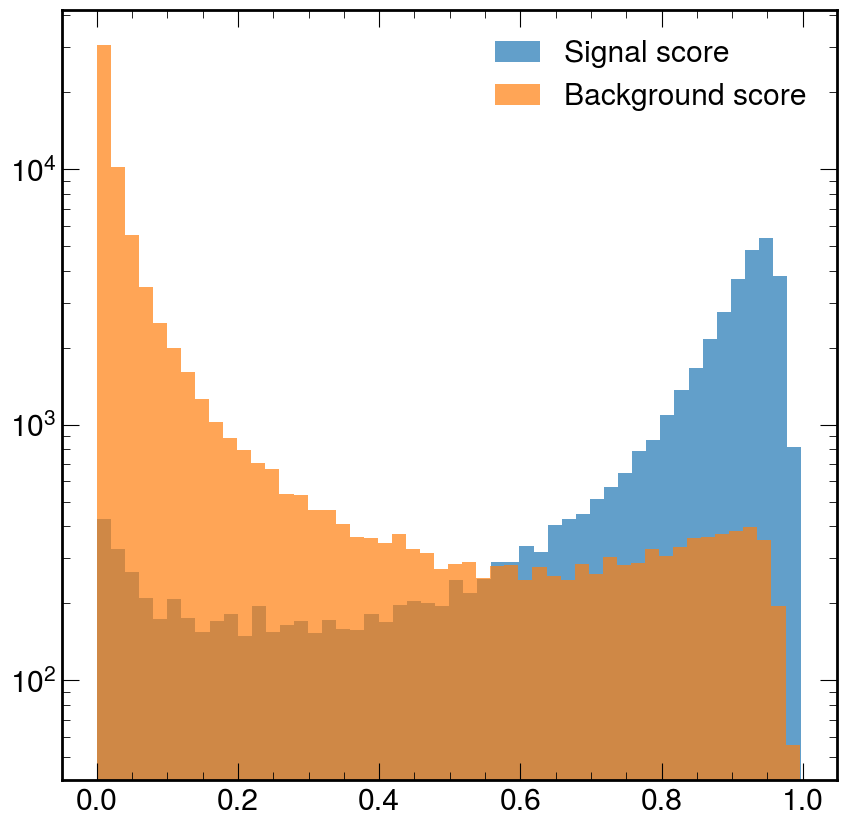

In [21]:
B_score = []
S_score = []
t = tqdm(range(0, len(y_pred)))

for i in t:
    if y_test[i]==0:
        B_score.append(y_pred[i])
    else:
        S_score.append(y_pred[i])
        
plt.hist(S_score, 50, label='Signal score', alpha=0.7)
plt.hist(B_score, 50, label='Background score', alpha=0.7)
plt.semilogy()
plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

/tmp/fkellere/ipykernel_1136860/2160272087.py:10: RuntimeWarning: divide by zero encountered in double_scalars
  Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/


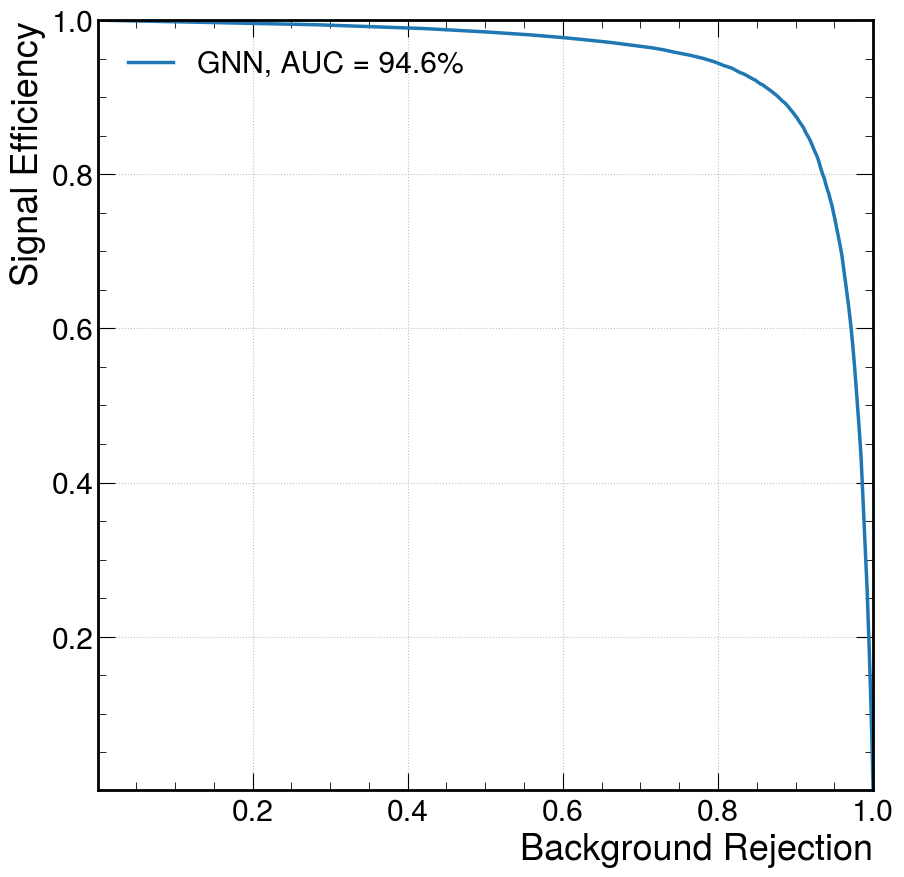

In [22]:
Seff = []
Brej = []
Figm = []
thre = np.linspace(min(y_pred),max(y_pred),100)
t    = tqdm(range(0,len(thre)))

for i in t:
    Seff.append(len([x for x in S_score if x>=thre[i]])/len(S_score))
    Brej.append(1-len([x for x in B_score if x>=thre[i]])/len(B_score))
    Figm.append(len([x for x in S_score if x>=thre[i]])*np.sqrt(len(B_score))/
            (np.sqrt(len([x for x in B_score if x>=thre[i]]))*len(S_score)))
    
plt.figure()
plt.plot(Brej, Seff, lw=2.5, label="GNN, AUC = {:.1f}%".format(auc(Brej,Seff)*100))
plt.xlabel(r'Background Rejection')
plt.ylabel(r'Signal Efficiency')
#plt.semilogx()
plt.ylim(0.001, 1)
plt.xlim(0.001, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

/tmp/fkellere/ipykernel_1136860/4116716709.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.plot(threshold_gnn,tpr_gnn/np.sqrt(fpr_gnn))
/tmp/fkellere/ipykernel_1136860/4116716709.py:3: RuntimeWarning: invalid value encountered in divide
  plt.plot(threshold_gnn,tpr_gnn/np.sqrt(fpr_gnn))


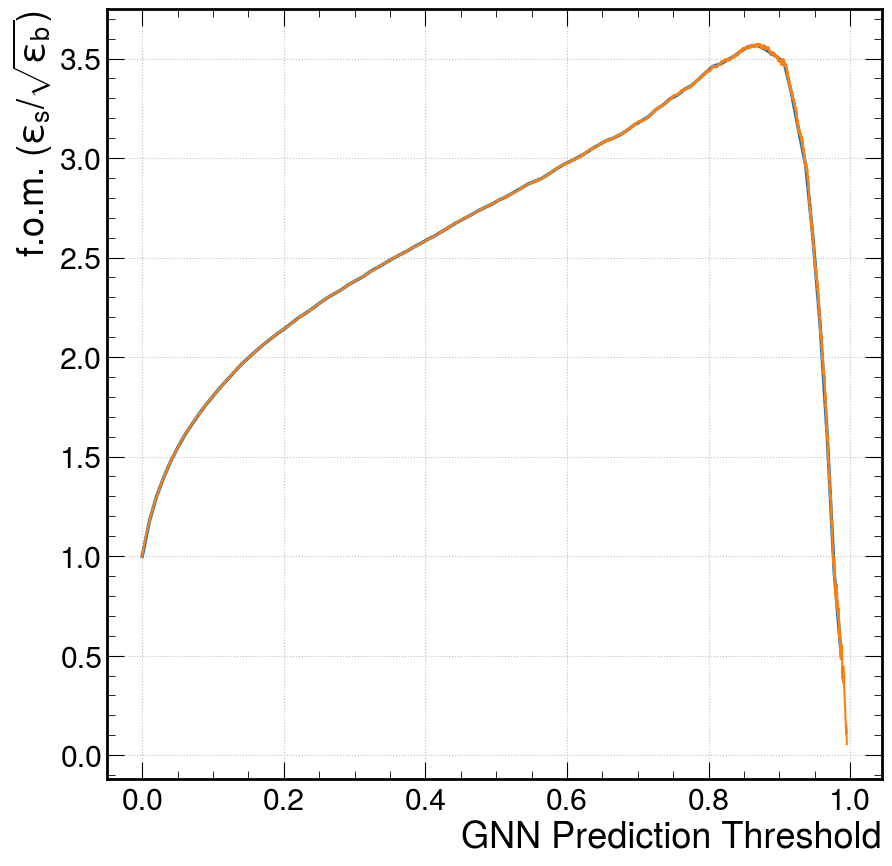

In [23]:
plt.figure()
plt.plot(thre, Figm, lw=2.5)
plt.plot(threshold_gnn,tpr_gnn/np.sqrt(fpr_gnn))
plt.xlabel(r'GNN Prediction Threshold')
plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
plt.grid(True)
plt.show()

In [10]:
thre_GCN = thre
Figm_GCN = Figm
Seff_GCN = Seff
Brej_GCN = Brej
%store thre_GCN
%store Figm_GCN
%store Seff_GCN
%store Brej_GCN

Stored 'thre_GCN' (ndarray)
Stored 'Figm_GCN' (list)
Stored 'Seff_GCN' (list)
Stored 'Brej_GCN' (list)


/tmp/fkellere/ipykernel_2633759/458101808.py:73: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/458101808.py:73: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/458101808.py:73: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/458101808.py:73: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/458101808.py:73: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipy

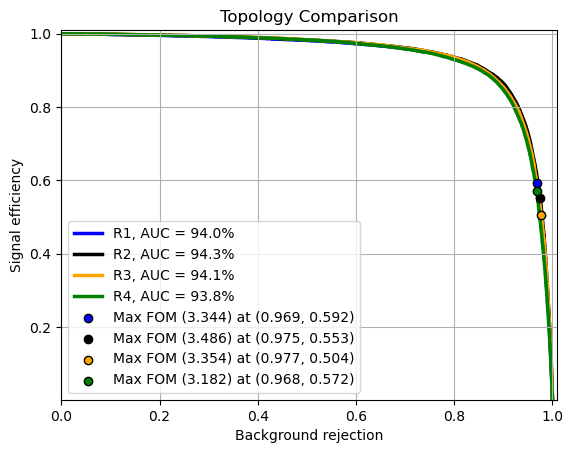

In [2]:
files_old = [
    "Old_Analysis/out_job_20250619_084047/Loss_RecoNew_all_10mm_R2_hitsopt.h5",
    "Old_Analysis/out_job_20251113_130042/Loss_TestBIG175R3strict.h5",
    "Old_Analysis/out_job_20250619_085714/Loss_RecoNew_all_10mm_KNN6_hitsopt.h5",
    "Old_Analysis/out_job_20250619_085805/Loss_RecoNew_all_10mm_KNN_hitsopt.h5",
    "Old_Analysis/out_job_20250619_091550/Loss_RecoNew_all_10mm_KNN20_hitsopt.h5",
    "Old_Analysis/out_job_20250708_174342/Loss_RecoNew_all_10mm_KNN30_hitsopt.h5",
    "Old_Analysis/out_job_20250708_174417/Loss_RecoNew_all_10mm_KNN40_hitsopt.h5",
    "Old_Analysis/out_job_20250623_144936/Scores_Fit.h5"
]
files = [
    "out_job_20260114_164621/Loss_RandomSampleFrom5M.h5",
    "out_job_20260115_102943/Loss_RandomSampleFrom5M.h5",
    "out_job_20260120_100906/Loss_RandomSampleFrom5M.h5",
    "out_job_20260119_165330/Loss_RandomSampleFrom5M.h5"
    ]
labels_old = [
    "R2",
    "R3",
    "KNN 6",
    "KNN 10",
    "KNN 20",
    "KNN 30",
    "KNN 40",
    "FC"
]
labels = [
    "R1",
    "R2",
    "R3",
    "R4"
]
colors_old = [
    "blue",
    "black",
    "orange",
    "green",
    "red",
    "brown",
    "pink",
    "purple"
]
colors = [
    "blue",
    "black",
    "orange",
    "green"
]
for i in range(len(files)):
    file = files[i]
    try:
        y_test  = pd.read_hdf(file,'y_test')
        y_pred  = pd.read_hdf(file,'y_predict_test')
        Ltrain  = pd.read_hdf(file,'loss_train')
        Lvalid  = pd.read_hdf(file,'loss_valid')
    except:
        y_test  = pd.read_hdf(file, 'y_test_S')
        y_pred  = pd.read_hdf(file, 'y_predict_S')

    #y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

    # create ROC curves
    try:
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
        y_test = y_test.to_numpy()
        y_pred = y_pred.to_numpy()
    except:
        y_test = np.array(y_test).flatten()
        y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    # plot ROC curves
    plt.plot(1-fpr_gnn, tpr_gnn, lw=2.5, color=colors[i], label=f"{labels[i]},"+" AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), zorder=1)
    fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
    opt_thresh = np.argmax(fom)
    plt.scatter(1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh], color=colors[i], edgecolor='black', linewidth=1., label="Max FOM ({:.3f}) at ({:.3f}, {:.3f})".format(max(fom),
                                                                                                                    1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh]), zorder=2) 
    plt.xlabel(r'Background rejection')
    plt.ylabel(r'Signal efficiency')
    #plt.semilogy()
    plt.ylim(0.001, 1.01)
    plt.xlim(0, 1.01)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.title('Topology Comparison')

/tmp/fkellere/ipykernel_2633759/1354046376.py:76: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/1354046376.py:76: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/1354046376.py:76: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/1354046376.py:76: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_2633759/1354046376.py:76: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkeller

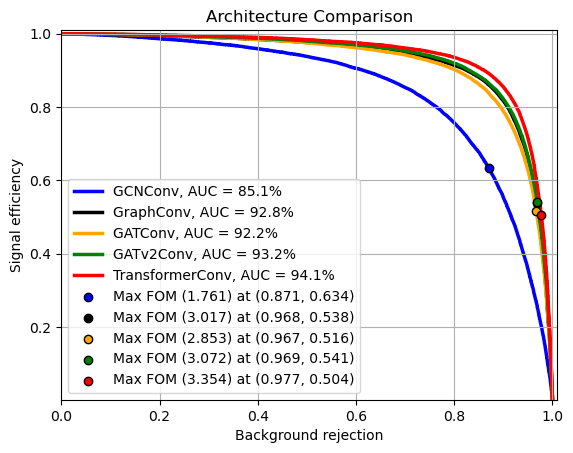

In [3]:
files_old = [
    "Old_Analysis/out_job_20251107_151256/Loss_TestBIG175R2.h5",
    "Old_Analysis/out_job_20251113_130119/Loss_TestBIG175R3.h5",
    "Old_Analysis/out_job_20251107_151416/Loss_TestBIG175KNN6.h5",
    "Old_Analysis/out_job_20251107_151500/Loss_TestBIG175KNN10.h5",
    "Old_Analysis/out_job_20251107_151521/Loss_TestBIG175KNN20.h5",
    "Old_Analysis/out_job_20251107_173434/Loss_TestBIG175KNN30.h5",
    "Old_Analysis/out_job_20251107_153615/Loss_TestBIG175KNN40.h5",
    "Old_Analysis/out_job_20251110_162727/Loss_TestBIG175FC.h5"
]
files = [
    "out_job_20260114_152407/Loss_RandomSampleFrom5M.h5",
    "out_job_20260114_152431/Loss_RandomSampleFrom5M.h5",
    "out_job_20260114_160115/Loss_RandomSampleFrom5M.h5",
    "out_job_20260119_165234/Loss_RandomSampleFrom5M.h5",
    "out_job_20260120_100906/Loss_RandomSampleFrom5M.h5"
    ]
labels_old = [
    "R2",
    "R3",
    "KNN 6",
    "KNN 10",
    "KNN 20",
    "KNN 30",
    "KNN40",
    "FC"
]
labels = [
    "GCNConv",
    "GraphConv",
    "GATConv",
    "GATv2Conv",
    "TransformerConv",
]
colors_old = [
    "blue",
    "black",
    "orange",
    "green",
    "red",
    "brown",
    "pink",
    "purple"
]
colors = [
    "blue",
    "black",
    "orange",
    "green",
    "red"
]
for i in range(len(files)):
    file = files[i]
    try:
        y_test  = pd.read_hdf(file,'y_test')
        y_pred  = pd.read_hdf(file,'y_predict_test')
        Ltrain  = pd.read_hdf(file,'loss_train')
        Lvalid  = pd.read_hdf(file,'loss_valid')
    except:
        y_test  = pd.read_hdf(file, 'y_test_S')
        y_pred  = pd.read_hdf(file, 'y_predict_S')

    #y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

    # create ROC curves
    try:
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
        y_test = y_test.to_numpy()
        y_pred = y_pred.to_numpy()
    except:
        y_test = np.array(y_test).flatten()
        y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    # plot ROC curves
    plt.plot(1-fpr_gnn, tpr_gnn, lw=2.5, color=colors[i], label=f"{labels[i]},"+" AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), zorder=1)
    fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
    opt_thresh = np.argmax(fom)
    plt.scatter(1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh], color=colors[i], edgecolor='black', linewidth=1., label="Max FOM ({:.3f}) at ({:.3f}, {:.3f})".format(max(fom),
                                                                                                                    1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh]), zorder=2) 
    plt.xlabel(r'Background rejection')
    plt.ylabel(r'Signal efficiency')
    #plt.semilogy()
    plt.ylim(0.001, 1.01)
    plt.xlim(0, 1.01)
    plt.grid(True)
    plt.legend(loc='lower left')
    plt.title('Architecture Comparison')

/tmp/fkellere/ipykernel_3050645/2351815845.py:43: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2351815845.py:43: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2351815845.py:43: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2351815845.py:43: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2351815845.py:43: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere

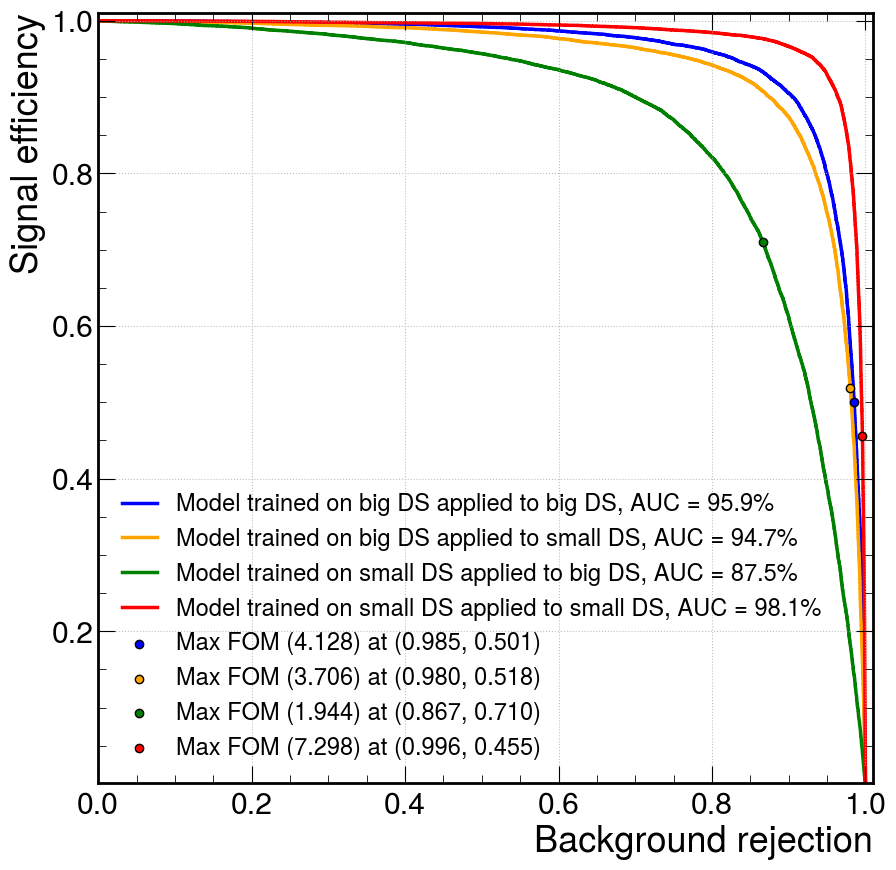

In [13]:
files = [
    "out_job_BIGDATASETKNN30R175/Scores_Training.h5",
    "out_job_BIGDATASETKNN30R175/Scores_SmallDS.h5",
    "out_job_20250708_174342/Scores_BIG175.h5",
    "out_job_20250708_174342/Loss_RecoNew_all_10mm_KNN30_hitsopt.h5"
]
labels = [
    "Model trained on big DS applied to big DS",
    "Model trained on big DS applied to small DS",
    "Model trained on small DS applied to big DS",
    "Model trained on small DS applied to small DS"
]
colors = [
    "blue",
    "orange",
    "green",
    "red"
]
for i in range(len(files)):
    file = files[i]
    try:
        y_test  = pd.read_hdf(file,'y_test')
        y_pred  = pd.read_hdf(file,'y_predict_test')
        Ltrain  = pd.read_hdf(file,'loss_train')
        Lvalid  = pd.read_hdf(file,'loss_valid')
    except:
        y_test  = pd.read_hdf(file, 'y_test_S')
        y_pred  = pd.read_hdf(file, 'y_predict_S')

    #y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

    # create ROC curves
    try:
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
        y_test = y_test.to_numpy()
        y_pred = y_pred.to_numpy()
    except:
        y_test = np.array(y_test).flatten()
        y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    # plot ROC curves
    plt.plot(1-fpr_gnn, tpr_gnn, lw=2.5, color=colors[i], label=f"{labels[i]},"+" AUC = {:.1f}%".format(auc(fpr_gnn,tpr_gnn)*100), zorder=1)
    fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
    opt_thresh = np.argmax(fom)
    plt.scatter(1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh], color=colors[i], edgecolor='black', linewidth=1., label="Max FOM ({:.3f}) at ({:.3f}, {:.3f})".format(max(fom),
                                                                                                                    1-fpr_gnn[opt_thresh], tpr_gnn[opt_thresh]), zorder=2) 
    plt.xlabel(r'Background rejection')
    plt.ylabel(r'Signal efficiency')
    #plt.semilogy()
    plt.ylim(0.001, 1.01)
    plt.xlim(0, 1.01)
    plt.grid(True)
    plt.legend(loc='lower left', fontsize=17)

/tmp/fkellere/ipykernel_3050645/2068824091.py:24: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2068824091.py:24: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2068824091.py:24: RuntimeWarning: divide by zero encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2068824091.py:24: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere/ipykernel_3050645/2068824091.py:24: RuntimeWarning: invalid value encountered in divide
  fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
/tmp/fkellere

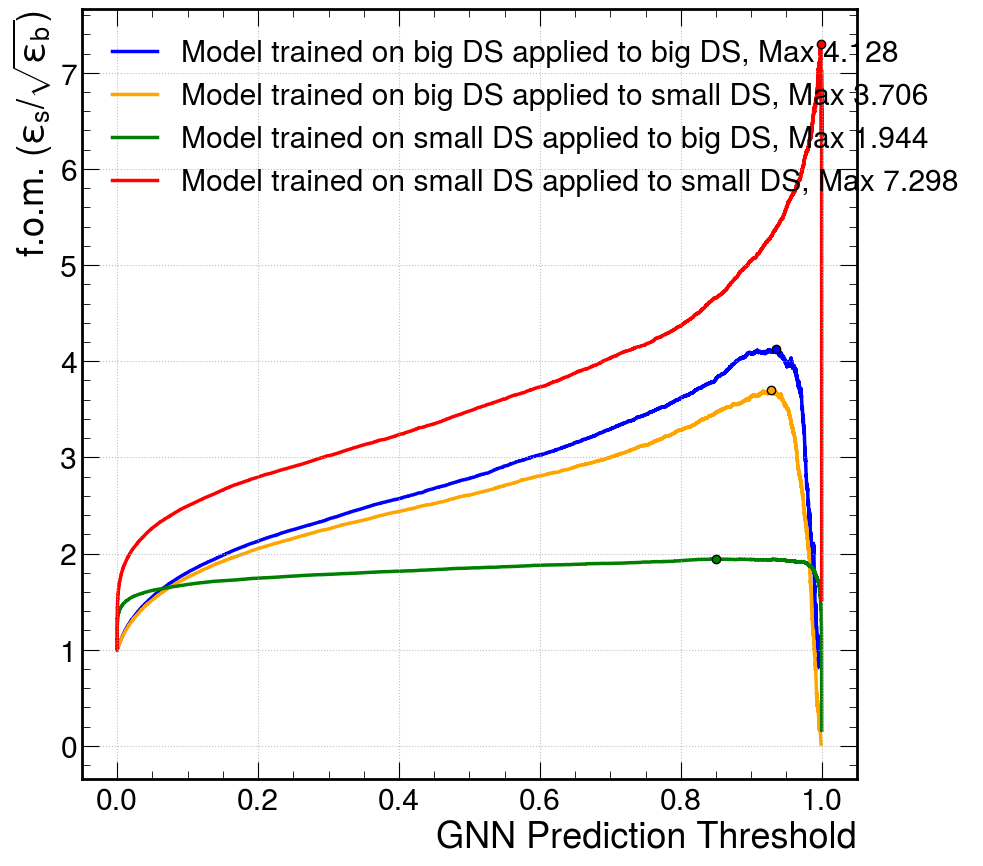

In [14]:
for i in range(len(files)):
    file = files[i]
    try:
        y_test  = pd.read_hdf(file,'y_test')
        y_pred  = pd.read_hdf(file,'y_predict_test')
        Ltrain  = pd.read_hdf(file,'loss_train')
        Lvalid  = pd.read_hdf(file,'loss_valid')
    except:
        y_test  = pd.read_hdf(file, 'y_test_S')
        y_pred  = pd.read_hdf(file, 'y_predict_S')

    #y_pred = np.exp(y_pred)/(1+np.exp(y_pred))

    # create ROC curves
    try:
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
        y_test = y_test.to_numpy()
        y_pred = y_pred.to_numpy()
    except:
        y_test = np.array(y_test).flatten()
        y_pred = np.array(y_pred['Predicted Probability Class 1']).flatten()
        fpr_gnn, tpr_gnn, threshold_gnn = roc_curve(y_test, y_pred)
    
    fom = np.nan_to_num(tpr_gnn / np.sqrt(fpr_gnn), nan=-np.inf, posinf=-np.inf, neginf=-np.inf)
    plt.plot(threshold_gnn,fom, lw=2.5, label=f"{labels[i]}, "+"Max {:.3f}".format(max(fom)), zorder=1, color=colors[i])
    opt_thresh = np.argmax(fom)
    plt.scatter(threshold_gnn[opt_thresh], fom[opt_thresh], color=colors[i], edgecolor='black', linewidth=1., zorder=2)
    plt.xlabel(r'GNN Prediction Threshold')
    plt.ylabel(r'f.o.m. ($\epsilon_{s}/\sqrt{\epsilon_{b}}$)')
    plt.grid(True)
    #plt.semilogy()
    plt.legend(loc='upper left')

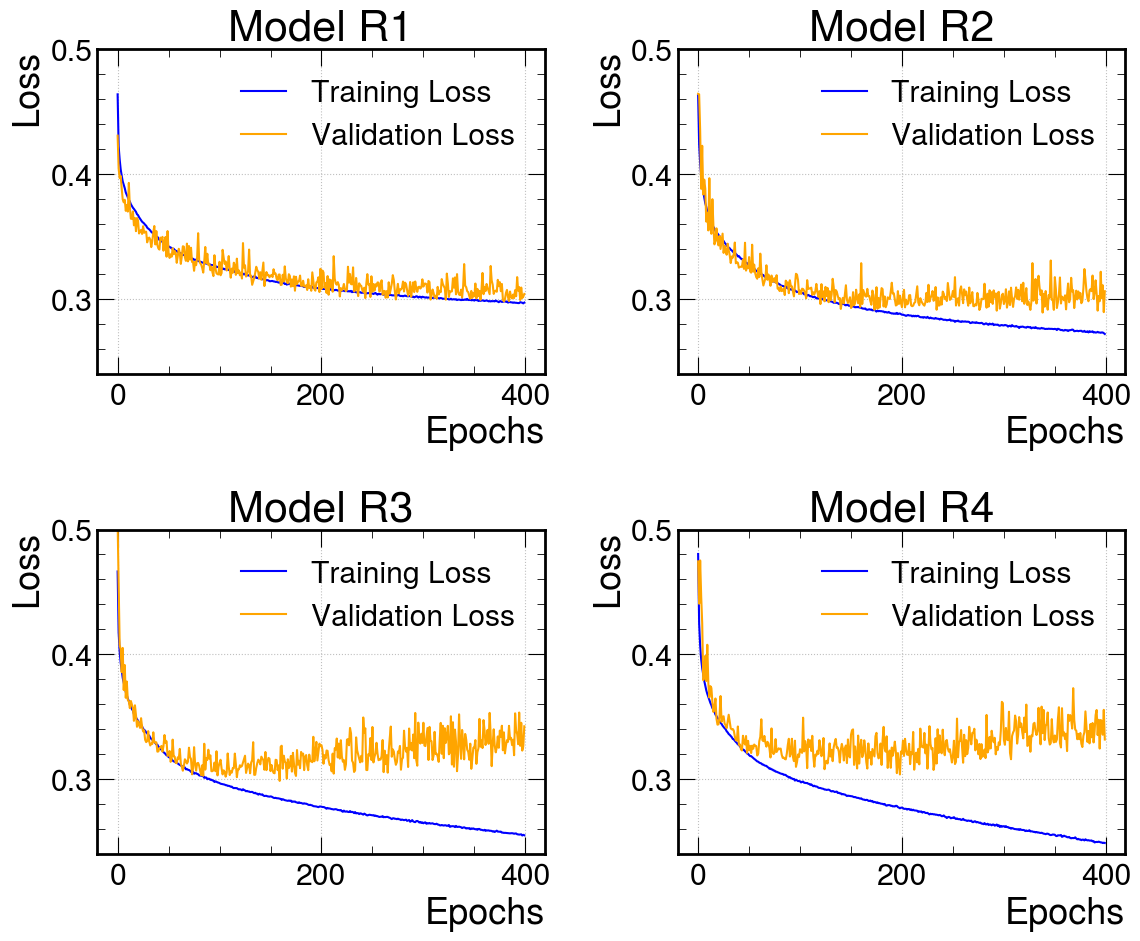

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the files and labels for the models
files = [
    "out_job_20260114_164621/Loss_RandomSampleFrom5M.h5",  # R1
    "out_job_20260115_102943/Loss_RandomSampleFrom5M.h5",  # R2
    "out_job_20260120_100906/Loss_RandomSampleFrom5M.h5",  # R3
    "out_job_20260119_165330/Loss_RandomSampleFrom5M.h5"   # R4
]
labels = ["R1", "R2", "R3", "R4"]
limits = (0.24,0.5)

# Create a 2x2 subplot
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

# Loop through the files and plot the training and validation loss curves
for i, file in enumerate(files):
    try:
        Ltrain = pd.read_hdf(file, 'loss_train')
        Lvalid = pd.read_hdf(file, 'loss_valid')
    except KeyError as e:
        print(f"Error loading data from {file}: {e}")
        continue

    # Plot the training and validation loss
    axes[i].plot(Ltrain, label='Training Loss', color='blue')
    axes[i].plot(Lvalid, label='Validation Loss', color='orange')
    axes[i].set_title(f"{labels[i]} Graphs")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")
    axes[i].set_ylim(limits)
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()

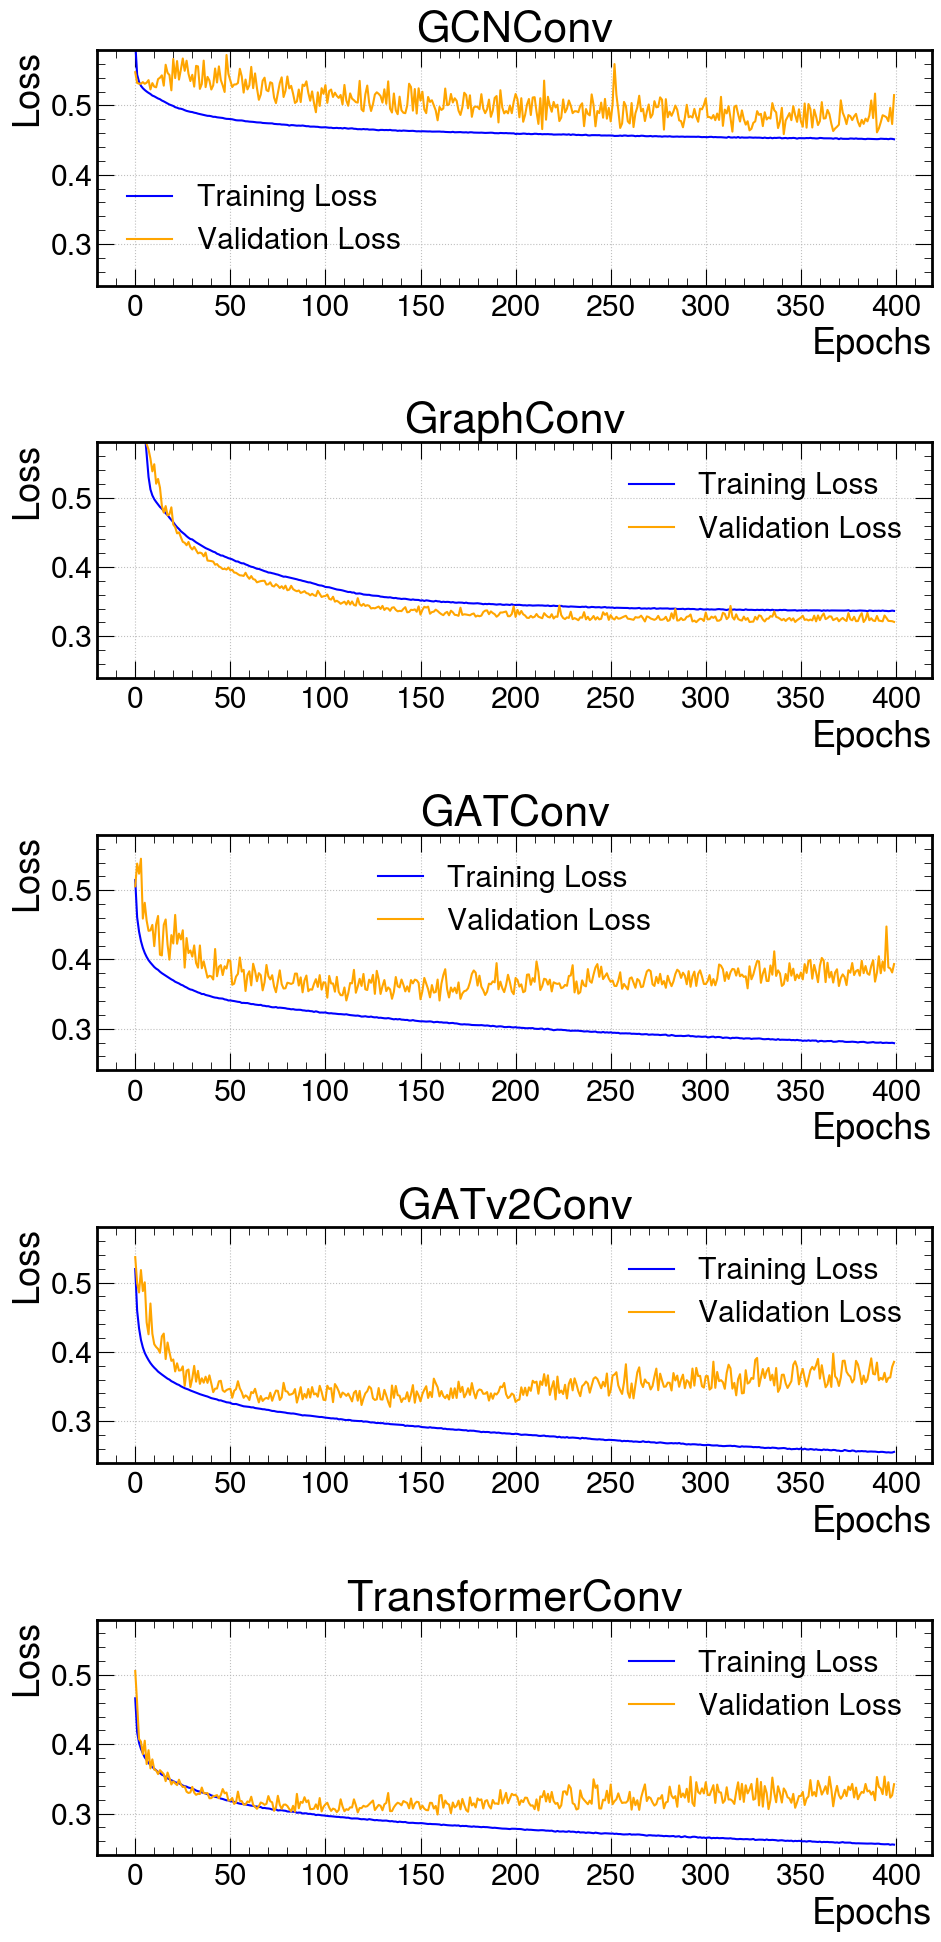

In [55]:
import matplotlib.pyplot as plt
import pandas as pd

# Define the files and labels for the models
files = [
    "out_job_20260114_152407/Loss_RandomSampleFrom5M.h5",  # GCNConv
    "out_job_20260114_152431/Loss_RandomSampleFrom5M.h5",  # GraphConv
    "out_job_20260114_160115/Loss_RandomSampleFrom5M.h5",  # GATConv
    "out_job_20260119_165234/Loss_RandomSampleFrom5M.h5",  # GATv2Conv
    "out_job_20260120_100906/Loss_RandomSampleFrom5M.h5"   # TransformerConv
]
labels = ["GCNConv", "GraphConv", "GATConv", "GATv2Conv", "TransformerConv"]
limits = (0.24,0.58)

# Create a figure with 5 subplots
fig, axes = plt.subplots(5, 1, figsize=(10, 20))

# Loop through the files and plot the training and validation loss curves
for i, file in enumerate(files):
    try:
        Ltrain = pd.read_hdf(file, 'loss_train')
        Lvalid = pd.read_hdf(file, 'loss_valid')
    except KeyError as e:
        print(f"Error loading data from {file}: {e}")
        continue

    # Plot the training and validation loss
    axes[i].plot(Ltrain, label='Training Loss', color='blue')
    axes[i].plot(Lvalid, label='Validation Loss', color='orange')
    axes[i].set_title(f"{labels[i]}")
    axes[i].set_xlabel("Epochs")
    axes[i].set_ylabel("Loss")
    axes[i].set_ylim(limits)
    axes[i].legend()
    axes[i].grid(True)

# Adjust layout and display the plot
plt.tight_layout()
plt.show()